# High-resolution UAV data

This lab presents a series of examples for working with high-resolution geospatial datasets captured by sensors on UAVs.

The data is captured over a cotton trial in New South Wales and the focus of lab activities is extracting variables that describe cotton plant condition from hyperspectral images and LiDAR derived surface models.

This lab will cover:

* Introducing hyperspectral data cubes and data structures and exploring hyperspectral data.
* Hyperspectral data pre-processing.
* Predicting cotton plant nitrogen levels from hyperspectral data.
* Combining hyperspectral data and LiDAR-derived data to compute canopy height and volume models.

## Setup

### Run the labs

You can run the labs locally on your machine or you can use cloud environments provided by Google Colab. **If you're working with Google Colab be aware that your sessions are temporary and, if required, you'll need to take care to save, backup, and download your work.**

<a href="https://colab.research.google.com/github/geog3300-agri3003/coursebook/blob/main/docs/notebooks/week-9.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Download data

To download the data for this lab run the following code snippet.

In [1]:
import os
import subprocess

if "data_lab-9" not in os.listdir(os.getcwd()):
    subprocess.run('wget -O data_lab-9.zip "https://dl.dropboxusercontent.com/scl/fi/em9snffp00tqxcq05j2f5/data_lab-9.zip?rlkey=hky02us6z0t48sugnkgx3h0x8&dl=0"', shell=True, capture_output=True, text=True)
    subprocess.run('unzip "data_lab-9.zip"', shell=True, capture_output=True, text=True)

### Install packages

If you're working in Google Colab, you'll need to install the required packages that don't come with the colab environment.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install xarray[complete]
    !pip install rioxarray
    !pip install mapclassify
    !pip install rasterio

### Import modules

In [4]:
import rioxarray as rxr
import xarray as xr
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

import rioxarray as rxr
import geopandas as gpd
import rasterio

from ipyleaflet import Map, ImageOverlay, basemaps
from ipywidgets import Output, VBox, HBox
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# setup renderer
if 'google.colab' in str(get_ipython()):
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "jupyterlab"

## Hyperspectral data cubes

Hyperspectral data is stored in a data cube structure. You can think of this as a 3D stack of arrays where the pixels in each array represent a location on the land surface. Each array in the stack represents a waveband.

The hyperspectral data we're working with has 172 wavebands with their wavelength listed below. Let's also read the hyperspectral data into our Python environment as a xarray `DataArray` object and explore its cube-like structure.

In [5]:
bands_nm = [
    399.309, 402.826, 406.344, 409.861, 413.378, 416.896, 420.413, 423.93,
    427.448, 430.965, 434.482, 438.0,   441.517, 445.034, 448.552, 452.069,
    455.586, 459.104, 462.621, 466.138, 469.656, 473.173, 476.69,  480.208,
    483.725, 487.242, 490.76,  494.277, 497.794, 501.312, 504.829, 508.346,
    511.864, 515.381, 518.898, 522.416, 525.933, 529.45,  532.968, 536.485,
    540.002, 543.519, 547.037, 550.554, 554.071, 557.589, 561.106, 564.623,
    568.141, 571.658, 575.175, 578.693, 582.21,  585.727, 589.245, 592.762,
    596.279, 599.797, 603.314, 606.831, 610.349, 613.866, 617.383, 620.901,
    624.418, 627.935, 631.453, 634.97,  638.487, 642.005, 645.522, 649.039,
    652.557, 656.074, 659.591, 663.109, 666.626, 670.143, 673.661, 677.178,
    680.695, 684.213, 687.73,  691.247, 694.765, 698.282, 701.799, 705.317,
    708.834, 712.351, 715.869, 719.386, 722.903, 726.421, 729.938, 733.455,
    736.973, 740.49,  744.007, 747.525, 751.042, 754.559, 758.077, 761.594,
    765.111, 768.628, 772.146, 775.663, 779.18,  782.698, 786.215, 789.732,
    793.25,  796.767, 800.284, 803.802, 807.319, 810.836, 814.354, 817.871,
    821.388, 824.906, 828.423, 831.94,  835.458, 838.975, 842.492, 846.01,
    849.527, 853.044, 856.562, 860.079, 863.596, 867.114, 870.631, 874.148,
    877.666, 881.183, 884.7,  888.218, 891.735, 895.252, 898.77,  902.287,
    905.804, 909.322, 912.839, 916.356, 919.874, 923.391, 926.908, 930.426,
    933.943, 937.46,  940.978, 944.495, 948.012, 951.53,  955.047, 958.564,
    962.082, 965.599, 969.116, 972.634, 976.151, 979.668, 983.185, 986.703,
    990.22,  993.737, 997.255, 1000.77
]

In [7]:
vnir_path = os.path.join("SAMPLE_AOI_CSIRO_Cotton1_VNIR_Orthomosaic_ESPG4326_v1.tif")
vnir_da = rxr.open_rasterio(vnir_path)
vnir_da["band"] = bands_nm
# scale to reflectance
vnir_da = vnir_da * 0.0001

If we print out a description of our `vnir_da` `DataArray` object we can see it has got cube like dimensions. The `x` and `y` dimensions correspond to a pixel's position and the `band` dimension corresponds to reflectance in different wavelengths.

In [ ]:
vnir_da

## Exploring hyperspectral data

Click on the image in the slippy map to generate spectral profile plots for the clicked location.

**What is the characteristic spectral reflectance feature of green vegetation?**

In [38]:
def interactive_spectral_profile(spectral_da, spectra_da_2=None):
    # Define map
    m = Map(center=(-30.267316273, 149.899925737), zoom=22, max_zoom=26)

    # Output widget for map and spectral profile plot
    out = Output()

    # Define click handler
    def handle_click_raw_vnir(**kwargs):
        """
        Display the spectral profile of a clicked point.
        Uses the raw hyperspectral reflectance.
        """
        if kwargs.get("type") == "click":
            latlng = kwargs.get("coordinates")
            with out:
                out.clear_output(wait=True)
                df = pd.DataFrame({"wavelength (nm)": bands_nm, "reflectance": spectral_da.sel(x=latlng[1], y=latlng[0], method="nearest").values})
                fig = px.line(
                    df,
                    x="wavelength (nm)",
                    y="reflectance",
                    template="plotly_white",
                )
                fig.show()


    # Add RGB image overlay
    overlay = ImageOverlay(
        url="https://raw.githubusercontent.com/geog3300-agri3003/lab-data/main/SAMPLE_AOI_CSIRO_Cotton1_RGB_Orthomosaic_6mm_EPSG_v1.png",
        bounds=[(-30.267316273, 149.899925737), (-30.267254275, 149.900012578)],
        opacity=0.6
    )
    m.add(overlay)

    # Register the click event handler with the map
    m.on_interaction(handle_click_raw_vnir)

    # Display map and spectral profile plot
    return HBox([m, out])

In [ ]:
interactive_spectral_profile(vnir_da)

#### Recap quiz

<details>
    <summary><b>Click on the RGB image of the cotton plants and view the spectral reflectance profiles. What are some of the dominant characteristics of cotton reflectance?</b></summary>

* There is a sharp increase in reflectance between 600 and 800 nm.
* There is a small peak in reflectance between 500 and 600 nm.
* There is short-run variation (noise) in the reflectance profiles, especially at wavelenghts > 800 nm.
</details>

## Hyperspectral data processing

Prior to analysing hyperspectral data cubes (e.g. prediction plant characteristics from spectral data), several data pre-processing steps are applied. Here, we'll focus on two pre-processing operations:

* **Smoothing** the reflectance values at each pixel to generate a smooth continuous spectral profile. There can be short-run noise in hyperspectral data due to atmospheric artefacts, illumination conditions, scattering effects due to plants and leaves, and noise introduced through sensing and capture conditions.
* **Vegetation masking** to remove background soil and other non-vegetative influenses. This allows us to focus only on using hyperspectral data to monitor plant conditions.

### Smoothing

A technique commonly used to smooth hyperspectral profiles is a Savitzky-Golay filter. This works by passing a moving window along the spectral data within each pixel and fitting a smooth curve through the values that fall within the moving window.

The below function demonstrates how to apply a Savitzky-Golay filter to an xarray `DataArray` and return a smoothed dataset. The function is setup to use a moving window length of 10 values (see the `window_length` parameter). You can change this, using a larger window will result in a smoother spectral profile. The goal is to pick a window length that's large enough to smooth out short-run noise in the time-series but the dominant spectral signatures relating to land surface conditions persist.

*Note, this function also returns the first derivative (rate of change) in spectral reflectance. This is just here for your reference as often the first derivative of hyperspectral data is used to detect change in vegetation conditions and charactersitics*

In [17]:
# Savitzky-Golay smoothing
def sg_smooth(da, window_length=10, polyorder=2):
    """
    Apply a Savitzky-Golay filter to a DataArray.
    """

    # smooth spectral reflectance values
    sg_arr = savgol_filter(
        da.values,
        window_length=window_length,
        polyorder=polyorder,
        axis=da.get_axis_num("band")
    )

    da_sg = xr.DataArray(
        sg_arr,
        coords=da.coords,
        dims=da.dims,
    )

    # compute 1st derivative of smoothed spectral reflectance
    sg_1d_arr = savgol_filter(
        da.values,
        window_length=window_length,
        polyorder=polyorder,
        axis=da.get_axis_num("band"),
        deriv=1,
    )

    da_sg_1d = xr.DataArray(
        sg_1d_arr,
        coords=da.coords,
        dims=da.dims,
    )

    return da_sg, da_sg_1d

Let's pass in our raw hyperspectral data and smooth it using a Savitzky-Golay filter. Then, let's use it to make an interactive plot. As you click on the  RGB image you should a smoother spectral profile for each clicked location.

In [18]:
vnir_da_sg, vnir_da_sg_1d = sg_smooth(vnir_da)

In [ ]:
interactive_spectral_profile(vnir_da_sg)

### Vegetation masks

There are a variety of techniques that are used for vegetation masking. Here, we'll use a simple NDVI threshold to create a binary vegetation and non-vegetation mask.

Computing normalised difference spectral indices is a common task when working with hyperspectral data (we have lots of wavebands we can use). Therefore, let's create convenience function that we can pass in two wavelengths and it will compute a normalised difference spectral index from the hyperspectral data cube.

In [20]:
def normalised_difference(da, band_1_nm, band_2_nm):
    """
    Calculate the normalised difference between two bands.
    """
    b1 = da.sel(band=band_1_nm, method="nearest")
    b2 = da.sel(band=band_2_nm, method="nearest")

    return (b1 - b2) / (b1 + b2)

Let's use the `normalised_difference()` function to compute the NDVI. To keep things simple we'll select the centre of the Sentinel-2 wavebands to represent red and near infrared reflectance.

**Look at the NDVI plot. What do you think would be a good threshold value to separate vegetation (cotton plants) and non-vegetation surfaces?**

In [ ]:
# mask out soil background
# S2 red = 665
# S2 nir = 865
ndvi = normalised_difference(vnir_da_sg, 865, 665)
ndvi.plot.imshow(cmap="Greens", robust=True, add_labels=False)

We can use xarray's `where()` function to set all NDVI values greater than a threshold to one and all other pixels to zero.

The `where()` function takes a condition as its first argument (e.g. `ndvi >= 0.7`). It's second argument is what value to assign the output in all locations where the condition is true and the third argument is the value to assign locations where the condition is false.

These are the docs for the <a href="https://docs.xarray.dev/en/stable/generated/xarray.where.html" target="_blank">where</a> function. It's worth being familiar with it as it's commonly used for processing raster and imagery data.

Here, we'll use an NDVI threshold of 0.7 and create a binary vegetation mask.

In [ ]:
veg_mask = xr.where(ndvi >= 0.7, 1, 0)
veg_mask.plot.imshow()

The final task is the apply the vegetation mask to our hyperspectral data cube setting all pixels where NDVI is less than threshold to a no data value.  

In [23]:
vnir_da_sg_veg = vnir_da_sg.where(veg_mask == 1)

#### Recap quiz

<details>
    <summary><b>Consider the strengths and weaknesses of using a NDVI threshold approach to create a vegetation mask? What other approaches could we use to do this?</b></summary>
    
Using an NDVI threshold approach to create vegetation masks is relatively simple to apply and it's easy to tune the threshold for for a given scene or image to obtain good results. You might want to use different thresholds at different stages of the growing season.

However, some drawbacks of using a simple NDVI thresholding approach are that is doesn't segment individual plants so you might get "noisy" isolated pixels classed as vegetation. **Look up <a href="https://segment-anything.com/" target="_blank">Segment Anything</a> and consider how that could be used to segment plants in a scene.** If you have multiple types of vegetation in a scene and you are only interested in one species, it can be hard to discriminate between them using a simple threshold. This could be the case if you want to separate a crop from the interrow vegetation. **Consider how you could use machine learning to segment out only pixels that relate to plant types of interest**.

</details>

## Exploring the red-edge

Several studies have highlighted that spectral reflectance between the red (~ 670 nm) and the near infrared (~ 800 nm) wavelengths characterise the condition and status of cotton plants. This portion of the electromagnetic spectrum is termed the *red-edge* due to the sharp increase in reflectance between the red wavelengths and the near infrared wavelengths in green vegetation. The red-edge is defined as the inflection point of the largest increase in reflectance between red and near infrared reflectance.

Chlorophyll in green plants absorb red light and near infrared light is reflected by the leaf's internal cell structure. Plants absorb red light for photosynthesis. Near infrared light is reflected (or transmitted through the leaf and re-scattered by the canopy) to avoid the energy damaging the plant.

Shifts in the position of the red-edge are indicators of plant stress. A shift in the red-edge position towards longer wavelengths is associated with an increase in chlorophyll and a shift towards shorter, red, wavelength is indicative of plant stress.

Studies have highlighted that changes in spectral reflectance in the red-edge portion of electromagnetic spectrum relate to biophyscical and biochemical variables such as chlorophyll concentration, leaf area index and nitrogren concentration.

With broadband multi-spectral images it is difficult to detect changes in the reflectance around red-edge, which can limit our ability to detect variation in plant condition. Consider the wavebands of the Landsat 8 OLI sensor below; it does not measure reflectance in the red-edge region. This means that any change in plant condition that cause in reflectance changes in the red-edge region would not be captured by the Landsat 8 sensor.  

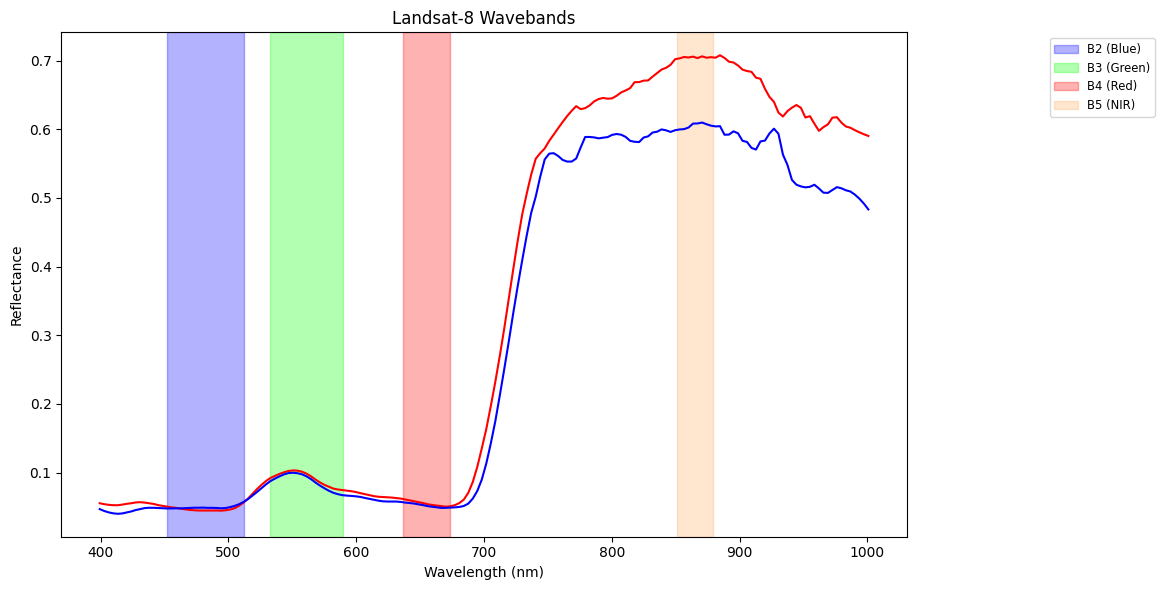

In [40]:
# Landsat 8 band metadata: (center wavelength [nm], bandwidth [nm], color)
bands = {
    'B2 (Blue)': (482, 60, '#0000ff'),
    'B3 (Green)': (561, 57, '#00ff00'),
    'B4 (Red)': (655, 37, '#ff0000'),
    'B5 (NIR)': (865, 28, '#fdae61'),
}

fig, ax = plt.subplots(figsize=(12, 6))
spectral_profile_1 = vnir_da_sg.sel(x=149.89996779710054, y=-30.26729097043827, method="nearest").values
spectral_profile_2 = vnir_da_sg.sel(x=149.89997752010822, y=-30.267298788893758, method="nearest").values
ax.plot(bands_nm, spectral_profile_1, color="red")
ax.plot(bands_nm, spectral_profile_2, color="blue")

# Plot vertical Landsat 8 bands
for name, (center, width, color) in bands.items():
    start = center - width / 2
    end = center + width / 2
    ax.axvspan(start, end, alpha=0.3, color=color, label=name)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")
ax.set_title("Landsat-8 Wavebands")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize="small")
plt.tight_layout()
plt.show()

The Sentinel-2 sensor has wavebands located within the red-edge spectrum (bands 5, 6 and 7 with a 20 m spatial resolution). This permits monitoring change in the reflectance properties of vegetation in red-edge portion of the spectrum, which could reflect change in plant condition.


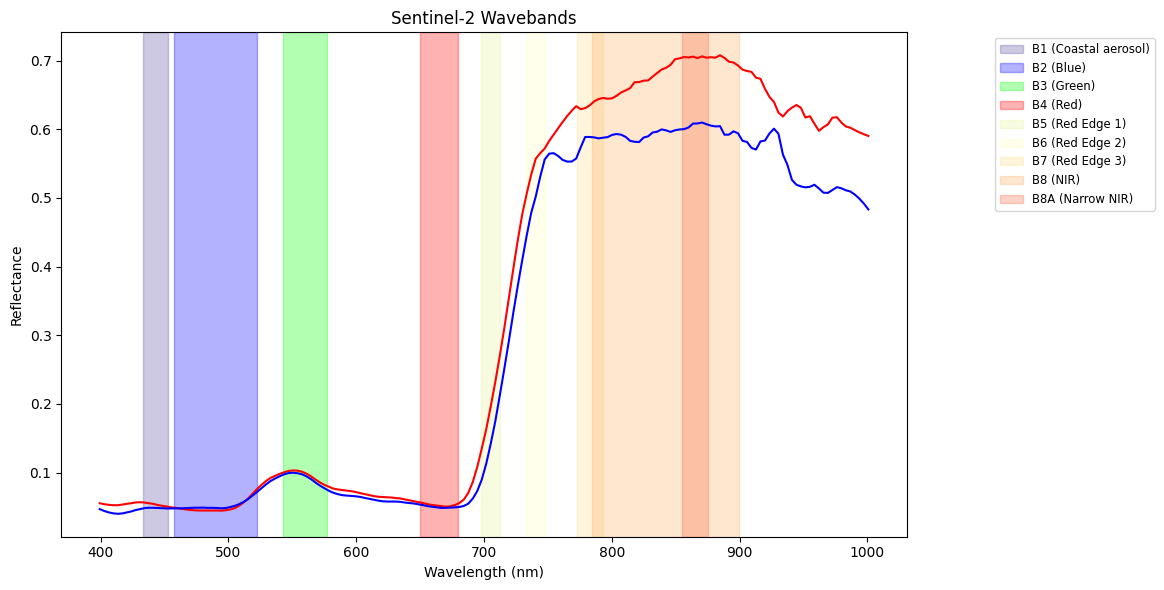

In [41]:
# Sentinel-2 waveband data (central wavelength in nm and bandwidth in nm)
bands = {
    'B1 (Coastal aerosol)': (443, 20, '#5e4fa2'),
    'B2 (Blue)': (490, 65, '#0000ff'),
    'B3 (Green)': (560, 35, '#00ff00'),
    'B4 (Red)': (665, 30, '#ff0000'),
    'B5 (Red Edge 1)': (705, 15, '#e6f598'),
    'B6 (Red Edge 2)': (740, 15, '#ffffbf'),
    'B7 (Red Edge 3)': (783, 20, '#fee08b'),
    'B8 (NIR)': (842, 115, '#fdae61'),
    'B8A (Narrow NIR)': (865, 20, '#f46d43'),
}

fig, ax = plt.subplots(figsize=(12, 6))
spectral_profile_1 = vnir_da_sg.sel(x=149.89996779710054, y=-30.26729097043827, method="nearest").values
spectral_profile_2 = vnir_da_sg.sel(x=149.89997752010822, y=-30.267298788893758, method="nearest").values
ax.plot(bands_nm, spectral_profile_1, color="red")
ax.plot(bands_nm, spectral_profile_2, color="blue")

# Plot vertical S2 bands
for name, (center, width, color) in bands.items():
    start = center - width / 2
    end = center + width / 2
    ax.axvspan(start, end, alpha=0.3, color=color, label=name)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")
ax.set_title("Sentinel-2 Wavebands")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize="small")
plt.tight_layout()
plt.show()


#### Recap quiz

<details>
    <summary><b>Given that the Sentinel-2 satellite captures reflectance in three red-edge bands, what is the value of UAV-based hyperspectral data for monitoring plant condition?</b></summary>

The spatial resolution of Sentinel-2's red-edge bands is 20 m (i.e. a 20 m pixel size). This is too coarse for characterising within-plant variability in biophysical and biochemical conditions and is too coarse for many within-field applications.

Reflectance in the red-edge portion of the spectrum is represented by three wavebands. In contrast, hyperspectral sensors capture a continuum of reflectance between the red and near infrared wavelengths. This might allow for detecting more subtle shifts in plant condition and for verifying insights derived from Sentinel-2 satellite images.
</details>

## Predicting nitrogen concentration

<a href="https://www.mdpi.com/2072-4292/13/8/1428" target="_blank">Marang et al. (2021)</a> combined hyperspectral data with field nitrogen (N) samples over a cotton trial (mature cotton stand) in New South Wales. This study explored how features in hyperspectral data could be used to predict N concentration of cotton leaves from hyperspectral images. They used machine learning to detect wavelengths in a hyperspectral image that were predictive of N concentration and created the following spectral index that aims to capture the red-edge position (inflection point ratio vegetation index).

$$
IPRVI = \frac{R_{695} - R_{700}}{R_{705}}
$$

Where $R_{695}$ is reflectance at 695 nm. They estimated a linear regression model to predict N concentration (%) as a function of IPRVI:

$$
N = 39.521 \centerdot IPRVI + 9.475
$$

We can apply this model to the hyperspectral data we are working with to create a predictive map of N concentration. The following is a function that takes in the hyperspectral data cube as an xarray `DataArray` object and returns an array representing predicted N concentration and the IPRVI.

Let's pass in the `DataArray` object that has had the vegetation mask applied so we only compute the IPRVI and N concentration for cotton plants.

In [26]:
def marang_n_conc_iprvi(da):
    """
    Calculate the N concentration from the IPRVI based on Marang et al., (2021).
    """
    iprvi = (da.sel(band=695, method="nearest") - da.sel(band=700, method="nearest")) / da.sel(band=705, method="nearest")
    n_conc = (39.521 * iprvi) + 9.475

    # plot N predictions and VI
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    n_conc.plot.imshow(robust=True, vmin=3.5, ax=axes[0])
    axes[0].set_title("Pred. N (%)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(None)
    iprvi.plot.imshow(robust=True, ax=axes[1])
    axes[1].set_title("IPRVI")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)
    plt.tight_layout()
    plt.show()

    return n_conc, iprvi

In [ ]:
n_conc, iprvi = marang_n_conc_iprvi(vnir_da_sg_veg)

#### Recap quiz

<details>
    <summary><b>Look at the map of predicted N concentration above, which areas have the highest N concentrations (i.e. yellow shades)? Can you look at the slippy RGB image of the cotton trial above and consider why these areas have high apparent N concentrations?</b></summary>
    
The areas with the highest predicted N concentrations appear on the left side of the middle rows of cotton plants. These areas look like shadow affected leaves and the high N concentrations could be an image artefact and not actual variability in N.

The lesson here is to always check imagery-derived products for artefacts. If we did not scrutinise this data we could risk using shadows to guide N management. When working with imagery-derived products it's important to be inquisitive and check the methods used to generate the imagery underlying predicted products. If possible, try and see the raw imagery.

**How could we try and remove the shadow affected leaves?**

</details>

<a href="https://www.mdpi.com/2072-4292/13/8/1428" target="_blank">Marang et al. (2021)</a> also publish a model that predicts N concentration using the normalised difference red edge index (NDRE). The NDRE is computed as:

$$
NDRE = \frac{R_{790} - R_{720}}{R_{790} + R_{720}}
$$

with the model to predict N concentration as:

$$
N = 12.856 \centerdot NDRE + 2.935
$$

<details>
    <summary><b>Using the example above that predicts N concentration as a function of the IPRVI, can you convert data in the hyperspectral data cube into a predicted N layer by applying the model above the NDRE values and plot the results?</b></summary>
    
```python
# predict N concentration
def marang_n_conc_ndre(da):
    """
    Calculate the N concentration from the NDRE based on Marang et al., (2021).
    """
    ndre = normalised_difference(da, 790, 720)
    n_conc = (12.856 * ccci) - 2.935

    # plot N predictions and VI
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    n_conc.plot.imshow(robust=True, vmin=0, ax=axes[0])
    axes[0].set_title("Pred. N (%)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(None)
    ndre.plot.imshow(robust=True, vmin=0.3, ax=axes[1])
    axes[1].set_title("NDRE")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)
    plt.tight_layout()
    plt.show()

    return n_conc, ndre

    n_conc, ndre = marang_n_conc_ndre(vnir_da_sg_veg)
```

</details>

<br>

<details>
    <summary><b>How similar are the predicted N concentration layers using IPRVI and NDRE data as inputs? How could / should you interpret the differences between these models when using this data for farm management? What could be potential causes of differences in N predictions?</b></summary>
    
Predicted N from the model using IPRVI is a lot higher than predicted N from the model using NDRE data as an input. We should explore why there are differences in predicted N before using these models for decision making.

There could be a few reasons why the models return different N predictions:

* Marang et al., use a relatively small ground truth dataset to fit the models (30 data points). This study is great at highlighting the potential to use hyperspectral data to characterise N variability within cotton fields. However, it's likely that more training and test data would be required to develop more general N prediction models.
* The sensors used to capture the hyperspectral data are different (spatial resolution and spectral resolution).
* The timing of image captures could be different. It could be that the relationships between spectral reflectance and N concentration vary through the growing season.

</details>

## Canopy surface models

This example demonstrates working with a very different type of high-resolution dataset from sensors onboard UAVs. Here, we will be working with raster elevation models derived from a LiDAR sensor that has scanned the canopy.

LiDAR stands for light detection and ranging where a laser scanner emits a laser pulse and measures the return time for pulse after it has bounced back off an object. The returns are converted into a point cloud representing the 3D structure of scene.

LiDAR processing software can filter the point clouds to create digital surface models and digital terrain models. A digital surface model (DSM) is a representation of the height of features on the land surface (e.g. the height of plants, trees, buildings). A digital terrain model (DTM) represents the height of the bare earth surface.

Let's read in a DSM and DTM for the cotton trial where we have just been working with hyperspectral data. We should be able to pick out the cotton plants in the DSM and as we're working in a small area of the field there should not be much variation in the DTM.

In [ ]:
dsm_path = os.path.join("SAMPLE_AOI_CSIRO_Cotton1_LiDAR_DSM_2cm_EPSG4326_v1.tif")
dsm_da = rxr.open_rasterio(dsm_path)
dsm_da

In [ ]:
dsm_da.sel(band=1).plot.imshow()

In [ ]:
dtm_path = os.path.join("SAMPLE_AOI_CSIRO_Cotton1_LiDAR_DTM_100cm_EPSG4326_v1.tif")
dtm_da = rxr.open_rasterio(dtm_path)
dtm_da

In [ ]:
dtm_da.sel(band=1).plot.imshow()

## Canopy height models

A canopy height model is just the height of the vegetation canopy at each location. To compute the canopy height model we need to mask out non-vegetated areas and then take the difference between the DSM and DTM. First, let's apply our vegetation mask to the DSM and DTM data.

In [33]:
dsm_veg = dsm_da.where(veg_mask == 1)
dtm_veg = dtm_da.where(veg_mask == 1)

Then we can subtract the DTM from the DSM to produce a canopy height model.

In [ ]:
chm = dsm_veg - dtm_veg
chm.sel(band=1).plot.imshow(robust=True)

## Canopy volume models

A canopy volume model is an estimate of the volume of vegetation at a location. It's computed as the area of a pixel multiplied by the height of vegetation at that location. It's a variable that's often used as an indicator of biomass.

The pixel dimensions for the data we're working with are approximately 15 cm. Thus, we can multiply each pixel in the canopy height model by `15 * 15` to estimate the canopy volume.

In [ ]:
cvm = chm * (15 * 15)
cvm.sel(band=1).plot.imshow(robust=True)